In [110]:
# data handling
import pandas as pd
pd.set_option('display.width', 140)

# numerical analysis
import numpy as np
np.set_printoptions(linewidth=140)

# OS-independent path
import pathlib

# data visualization (See Preprocessing -> Exploratory Data Analysis)
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/JoseGuzman/minibrain/master/minibrain/paper.mplstyle') # minibrain plotting

# Display Pipelines and models
from sklearn import set_config
set_config(display='diagram')

# other (e.g. for python >=3.6 type definitions like age: int = 1)
from typing import List, Tuple

# A progress bar
from tqdm import tqdm

# custom utility script (https://www.kaggle.com/code/joseguzman/reducing)
#from reducing import PandaReducer
import sys
sys.path.append('/Downloads/Assignment/')
#import reducing

# Data Loading

In [111]:
# Data Loading
# Define file paths, test and train files
mypath = pathlib.Path('data/')
train_file = mypath / 'train.csv'
test_file = mypath / 'test.csv'
type(test_file)

pathlib.PosixPath

In [112]:
"""
reducing.py

This script is adapted from https://www.kaggle.com/code/wkirgsn/fail-safe-parallel-memory-reduction
Author: Kirgsn, 2018

How to use it in Kaggle:
1. Open a notebook and click File->Add Utility Script

Usage:
>>> from reducing import PandaReducer
>>> new_df = PandaReducer().reduce(df)
"""
import numpy as np
import pandas as pd

import time
import gc

from joblib import Parallel, delayed
from fastprogress import progress_bar

__all__ = ['PandaReducer']

def measure_time_mem(func):
    def wrapped_reduce(self, df:pd.DataFrame, *args, **kwargs)-> pd.DataFrame:
        
        # start time
        mem_init = df.memory_usage().sum() / self.memory_scale_factor
        start_time = time.time()
        
        # execute target function
        new_df = func(self, df, *args, **kwargs)
        
        # end time 
        mem_new = new_df.memory_usage().sum() / self.memory_scale_factor
        end_time = time.time()
        
        percentage = 100 * (mem_init - mem_new)/ mem_init 
        msg = 'Dataset reduced {0:.2f}% : {1:.2f} to {2:.2f} MB'.format(percentage, mem_init, mem_new)
        print(f'{msg} in {(end_time - start_time):.2f} seconds')
        
        gc.collect()
        return new_df
    
    return wrapped_reduce


class PandaReducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe into, in order to save memory.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, use_categoricals:bool = True, n_jobs:int = -1):
        """
        use_categoricals: (bool) 
            Whether the new pandas dtype "Categoricals" shall be used.
        
        n_jobs: (int)
            number of parallel jobs, default (-1) use all available.
        """
       
        #dict with np.dtypes-strings as keys
        self.conversion_table = {
            'int': [np.int8, np.int16, np.int32, np.int64],
            'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
            'float': [np.float32, ]
        }
        
        self.null_int = {   
            np.int8:  pd.Int8Dtype,
            np.int16: pd.Int16Dtype,
            np.int32: pd.Int32Dtype,
            np.int64: pd.Int64Dtype,
            np.uint8: pd.UInt8Dtype,
            np.uint16:pd.UInt16Dtype,
            np.uint32:pd.UInt32Dtype,
            np.uint64:pd.UInt64Dtype
        }
        
        self.use_categoricals = use_categoricals
        self.n_jobs = n_jobs

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    @measure_time_mem
    def reduce(self, df:pd.DataFrame, verbose:bool = False)-> pd.DataFrame:
        """
        Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        df: (pd.DataFrame)
        the Pandas dataframe to be reduced.
        
        verbose: (bool) 
            If True, outputs more information
        
        Returns 
        
        pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=self.n_jobs, max_nbytes=None)(progress_bar(list(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)))

        del df
        gc.collect()
        return pd.concat(ret_list, axis=1)

    def _reduce(self, series:pd.Series, colname:str, verbose:bool):
        """
        Real reduce function
        
        series (pd.Series)
        A Series object of a panda
        
        colname (str)
        
        """
        try:
            isnull = False
            # skip NaNs
            if series.isnull().any():
                isnull = True
            # detect kind of type
            coltype = series.dtype
            if np.issubdtype(coltype, np.integer):
                conv_key = 'int' if series.min() < 0 else 'uint'
            elif np.issubdtype(coltype, np.floating):
                conv_key = 'float'
                asint = series.fillna(0).astype(np.int64)
                result = (series - asint)
                result = np.abs(result.sum())
                if result < 0.01:
                    conv_key = 'int' if series.min() < 0 else 'uint'
            else:
                if isinstance(coltype, object) and self.use_categoricals:
                    # check for all-strings series
                    if series.apply(lambda x: isinstance(x, str)).all():
                        if verbose: print(f'convert {colname} to categorical')
                        return series.astype('category')
                if verbose: print(f'{colname} is {coltype} - Skip..')
                return series
            # find right candidate
            for cand, cand_info in self._type_candidates(conv_key):
                if series.max() <= cand_info.max and series.min() >= cand_info.min:
                    if verbose: print(f'convert {colname} to {cand}')
                    if isnull:
                        return series.astype(self.null_int[cand]())
                    else:
                        return series.astype(cand)

            # reaching this code is bad. Probably there are inf, or other high numbs
            print(f"WARNING: {colname} doesn't fit the grid with \nmax: {series.max()} "
                f"and \nmin: {series.min()}")
            print('Dropping it..')
        except Exception as ex:
            print(f'Exception for {colname}: {ex}')
            return series

In [113]:
# Data Loading
def data_loader(file:pathlib.PosixPath, target:str=None, verbose:bool = False, **kwargs) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Loads csv file and return a tuple with a pandas dataset 
    containing all features, and a pandas Series with the 
    target variable.
    """
    
    data = pd.read_csv(file, **kwargs)
    df = PandaReducer().reduce(data) # see reduce.py in Utility Script 
    
    if target is not None:
        out = (df[target]).astype(int)
        df.drop([target], axis=1, inplace=True)
    else:
        out = None
        
    
    if verbose:
        print('The dataset contains {0} entries and {1} features'.format(*df.shape))
    
    return df, out


In [114]:
# Data Loading
train, train_target = data_loader(file = train_file, target = 'Class/ASD', verbose=True, index_col='ID')
test, _ = data_loader(file = test_file, target=None, verbose=True, index_col='ID') # note target is None

Dataset reduced 79.61% : 0.13 to 0.03 MB in 1.39 seconds
The dataset contains 800 entries and 20 features


Dataset reduced 78.07% : 0.03 to 0.01 MB in 0.09 seconds
The dataset contains 200 entries and 20 features


In [115]:
train.head(n=5)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
ID,,,,,,,,,,,,,,,,,,,,
1,1,0,1,1,1,1,0,1,1,1,18.605396,f,White-European,no,no,United States,no,7.819715,18 and more,Self
2,0,0,0,0,0,0,0,0,0,1,13.829370,f,South Asian,no,no,Australia,no,10.544296,18 and more,?
3,1,1,1,1,1,1,0,0,1,1,14.679893,f,White-European,no,no,United Kingdom,no,13.167506,18 and more,Self
4,0,0,0,1,0,0,0,0,0,0,61.035290,f,South Asian,no,no,New Zealand,no,1.530098,18 and more,?
5,0,0,0,0,1,0,0,0,1,1,14.256686,m,Black,no,yes,Italy,no,7.949723,18 and more,Self


In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   A1_Score         800 non-null    uint8   
 1   A2_Score         800 non-null    uint8   
 2   A3_Score         800 non-null    uint8   
 3   A4_Score         800 non-null    uint8   
 4   A5_Score         800 non-null    uint8   
 5   A6_Score         800 non-null    uint8   
 6   A7_Score         800 non-null    uint8   
 7   A8_Score         800 non-null    uint8   
 8   A9_Score         800 non-null    uint8   
 9   A10_Score        800 non-null    uint8   
 10  age              800 non-null    float32 
 11  gender           800 non-null    category
 12  ethnicity        800 non-null    category
 13  jaundice         800 non-null    category
 14  austim           800 non-null    category
 15  contry_of_res    800 non-null    category
 16  used_app_before  800 non-null    category
 1

In [117]:
# Exploration: there are no missing values in both train and test datasets
test.isnull().values.any(), train.isnull().values.any() # 

(False, False)

In [118]:
# Exploration: evaluate if data is uniformly distributed
train_target.value_counts() # data is umbalanced!

0    615
1    185
Name: Class/ASD, dtype: int64

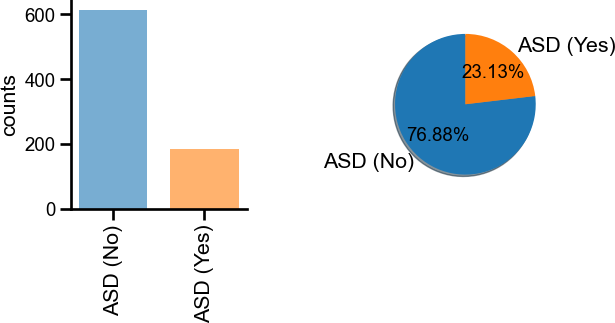

In [119]:
# Exploration: visualization of target variable

autistic = train_target.value_counts() 

fig, ax = plt.subplots(1,2, figsize =(6,3))
fig.tight_layout(pad = 1, h_pad = 2, w_pad = 4)

mylabels = ['ASD (No)', 'ASD (Yes)']
mycolors = ['tab:blue', 'tab:orange']

ax[0].bar(x=mylabels, height = autistic, color = mycolors, width = 0.75, alpha = .6)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_ylabel('counts')#, ax[0].set_yticks(np.arange(0,4000,500))

ax[1].pie(autistic.values, labels = mylabels, colors = mycolors, autopct='%2.2f%%',shadow=True, startangle=90);

In [120]:
train.describe() # numeric variables, 

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,800.000000,800.00000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.582500,0.28625,0.321250,0.41500,0.457500,0.20875,0.273750,0.717500,0.316250,0.460000,28.612303,7.058527
std,0.493455,0.45229,0.467249,0.49303,0.498502,0.40667,0.446161,0.450497,0.465303,0.498709,12.872375,3.788970
min,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,9.560505,-2.594654
25%,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,19.282082,4.527556
50%,1.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,25.479960,6.893472
75%,1.000000,1.00000,1.000000,1.00000,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,33.154757,9.892981
max,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,72.402489,13.390868


In [121]:
test.describe() # numeric variables, 

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.585000,0.285000,0.355000,0.450000,0.475000,0.21000,0.285000,0.725000,0.330000,0.390000,27.875051,6.912688
std,0.493958,0.452547,0.479714,0.498742,0.500628,0.40833,0.452547,0.447635,0.471393,0.488974,12.489215,3.949887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,7.822865,-1.721289
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,18.889948,4.303175
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,24.754095,7.138223
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,31.165790,9.756596
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,66.163940,13.369400


In [122]:
test.rename(columns={'austim':'autism'}, inplace=True)

In [123]:
test.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'autism', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation'],
      dtype='object')

In [124]:
train.rename(columns={'austim':'autism'}, inplace=True)

In [125]:
train.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'autism', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation'],
      dtype='object')

In [126]:
test.rename(columns={'contry_of_res':'country_of_res'}, inplace=True)

In [127]:
test.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'autism', 'country_of_res', 'used_app_before', 'result', 'age_desc', 'relation'],
      dtype='object')

In [128]:
train.rename(columns={'contry_of_res':'country_of_res'}, inplace=True)

In [129]:
train.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'autism', 'country_of_res', 'used_app_before', 'result', 'age_desc', 'relation'],
      dtype='object')

In [130]:
# train.select_dtypes(['category']) # category variables

for col in train.select_dtypes(['category']).columns :
    myval = train[col].unique().tolist()
    if len(myval) == 2:
        print(f'BIVARIATE   : {col} -> {train[col].unique().tolist()}')
    elif len(myval) == 1:
        print(f'UNIVARIATE   : {col} -> {train[col].unique().tolist()}')
    else:
        print(f'MULTIVARIATE: {col} -> {train[col].unique().tolist()}')

BIVARIATE   : gender -> ['f', 'm']
MULTIVARIATE: ethnicity -> ['White-European', 'South Asian', 'Black', 'Asian', 'Middle Eastern ', '?', 'others', 'Latino', 'Turkish', 'Others', 'Hispanic', 'Pasifika']
BIVARIATE   : jaundice -> ['no', 'yes']
BIVARIATE   : autism -> ['no', 'yes']
MULTIVARIATE: country_of_res -> ['United States', 'Australia', 'United Kingdom', 'New Zealand', 'Italy', 'Nicaragua', 'Canada', 'United Arab Emirates', 'Netherlands', 'Sri Lanka', 'India', 'Armenia', 'Sierra Leone', 'Argentina', 'Azerbaijan', 'Iceland', 'Egypt', 'Serbia', 'Afghanistan', 'Costa Rica', 'Jordan', 'Angola', 'Pakistan', 'Brazil', 'Ireland', 'Kazakhstan', 'Viet Nam', 'Ethiopia', 'Austria', 'Finland', 'France', 'Malaysia', 'Japan', 'Spain', 'Philippines', 'Iran', 'Czech Republic', 'Russia', 'Romania', 'Mexico', 'Belgium', 'Aruba', 'Uruguay', 'Indonesia', 'Ukraine', 'AmericanSamoa', 'Germany', 'China', 'Iraq', 'Tonga', 'South Africa', 'Saudi Arabia', 'Hong Kong', 'Bahamas', 'Ecuador', 'Cyprus', 'Bangl

In [131]:
for col in test.select_dtypes(['category']).columns :
    myval = test[col].unique().tolist()
    if len(myval) == 2:
        print(f'BIVARIATE   : {col} -> {test[col].unique().tolist()}')
    elif len(myval) == 1:
        print(f'UNIVARIATE   : {col} -> {test[col].unique().tolist()}')
    else:
        print(f'MULTIVARIATE: {col} -> {test[col].unique().tolist()}')

BIVARIATE   : gender -> ['m', 'f']
MULTIVARIATE: ethnicity -> ['Asian', '?', 'Middle Eastern ', 'White-European', 'Latino', 'Pasifika', 'Black', 'Hispanic', 'South Asian', 'Others', 'Turkish', 'others']
BIVARIATE   : jaundice -> ['no', 'yes']
BIVARIATE   : autism -> ['no', 'yes']
MULTIVARIATE: country_of_res -> ['United Arab Emirates', 'New Zealand', 'Austria', 'Bahamas', 'Australia', 'Jordan', 'United States', 'Russia', 'Ethiopia', 'Belgium', 'India', 'United Kingdom', 'Mexico', 'AmericanSamoa', 'Armenia', 'Pakistan', 'Canada', 'Netherlands', 'Afghanistan', 'Iraq', 'Brazil', 'Spain', 'France', 'Burundi', 'Iran', 'Argentina', 'Angola', 'Germany', 'Philippines', 'Sri Lanka', 'Serbia', 'Kazakhstan', 'Malaysia', 'South Africa', 'Egypt', 'Viet Nam', 'Iceland', 'Lebanon', 'Italy', 'Saudi Arabia', 'Romania', 'Ukraine', 'Azerbaijan', 'Ireland']
BIVARIATE   : used_app_before -> ['no', 'yes']
UNIVARIATE   : age_desc -> ['18 and more']
MULTIVARIATE: relation -> ['?', 'Parent', 'Self', 'Relative'

In [132]:
train['age_desc'].unique(), test['age_desc'].unique() # this variable is not informative, we will remove it

(['18 and more']
 Categories (1, object): ['18 and more'],
 ['18 and more']
 Categories (1, object): ['18 and more'])

In [133]:
# let me check if both datasets relations are idential
print(f'{"test":25s} --   {"train":10s}')
print(f'{"="*45}')
for i,j in zip(np.sort(test.relation.unique()), np.sort(train.relation.unique())):
    print(f'{i:25s} --   {j:15s}')
    
len(test.relation.unique()), len(train.relation.unique())  

test                      --   train     
?                         --   ?              
Health care professional  --   Health care professional
Others                    --   Others         
Parent                    --   Parent         
Relative                  --   Relative       
Self                      --   Self           


(6, 6)

In [134]:
# let me check if both datasets are representatives
print(f'{"test":15s} --   {"train":10s}')
print(f'{"="*35}')
for i,j in zip(np.sort(test.ethnicity.unique()), np.sort(train.ethnicity.unique())):
    print(f'{i:15s} --   {j:15s}')
len(test.ethnicity.unique()), len(train.ethnicity.unique())

test            --   train     
?               --   ?              
Asian           --   Asian          
Black           --   Black          
Hispanic        --   Hispanic       
Latino          --   Latino         
Middle Eastern  --   Middle Eastern 
Others          --   Others         
Pasifika        --   Pasifika       
South Asian     --   South Asian    
Turkish         --   Turkish        
White-European  --   White-European 
others          --   others         


(12, 12)

In [135]:
for i,j in enumerate(np.sort(test.ethnicity.unique())):
    print(f'{i:2d} --   {j:15s}')

 0 --   ?              
 1 --   Asian          
 2 --   Black          
 3 --   Hispanic       
 4 --   Latino         
 5 --   Middle Eastern 
 6 --   Others         
 7 --   Pasifika       
 8 --   South Asian    
 9 --   Turkish        
10 --   White-European 
11 --   others         


In [136]:
for i,j in enumerate(np.sort(train.ethnicity.unique())):
    print(f'{i:2d} --   {j:15s}')

 0 --   ?              
 1 --   Asian          
 2 --   Black          
 3 --   Hispanic       
 4 --   Latino         
 5 --   Middle Eastern 
 6 --   Others         
 7 --   Pasifika       
 8 --   South Asian    
 9 --   Turkish        
10 --   White-European 
11 --   others         


In [137]:
train['ethnicity'].value_counts()

White-European     211
?                  151
Asian              134
Middle Eastern     116
Black               45
Latino              44
South Asian         35
Others              24
Pasifika            18
Hispanic            16
Turkish              4
others               2
Name: ethnicity, dtype: int64

In [138]:
# ? is others in ethnicity and relation for training set

# for train set:
train.ethnicity[train['ethnicity'] =='others'] = '?'
train['ethnicity'].value_counts()
    
#for test set:
test.ethnicity[test['ethnicity'] =='?'] = 'others'
test['ethnicity'].value_counts()

White-European     48
others             38
Middle Eastern     34
Asian              31
Black              10
South Asian         9
Latino              7
Pasifika            7
Turkish             7
Others              5
Hispanic            4
?                   0
Name: ethnicity, dtype: int64

In [139]:
# If different ethnicit this will affect one-hot-encoding
len(test.ethnicity.unique()), len(train.ethnicity.unique())

(11, 11)

In [140]:
# for train set:
train.relation[train['relation'] =='Others'] = '?'
#train['relation'].value_counts()
    
#for test set:
test.relation[test['relation'] =='Others'] = '?'
test['relation'].value_counts()

Self                        166
?                            15
Relative                     10
Parent                        8
Health care professional      1
Others                        0
Name: relation, dtype: int64

In [141]:
# If different ethnicit this will affect one-hot-encoding
len(test.relation.unique()), len(train.relation.unique())

(5, 5)

In [142]:
# Different ethnicities, this will affect one-hot-encoding!!!
len(train['country_of_res'].unique()), len(test['country_of_res'].unique())

(61, 44)

In [143]:
#Different countries, this will affect one-hot-encoding
np.array_equiv(train['country_of_res'].unique(), test['country_of_res'].unique())

False

In [144]:
# We will map country

# Load the dataset of country/region
data = pd.read_csv('data/continents.csv') # small dataset, no need to reduce size
#data = pd.read_csv('country-mapping-iso-continent-region/continents2.csv') # small dataset, no need to reduce size


#print(data.region.unique())
continent = pd.Series(data.region.values, index = data.name).to_dict() # create a dictionary
continent['Antarctica'] = 'Antarctica'

In [145]:
# Viet Nam should be Vietnam
train[train['country_of_res'] == 'Viet Nam'].index

Int64Index([77, 130, 170, 488, 711, 795], dtype='int64', name='ID')

In [146]:
# AmericanSamoa should be American Samoa
train[train['country_of_res'] == 'AmericanSamoa'].index

Int64Index([318, 616], dtype='int64', name='ID')

In [147]:
true_idx = train_target[(train_target==1)].index 
false_idx = train_target[(train_target==0)].index
#np.sum([(train_target==0) & (train['country_of_res']=='United States')])

In [148]:
# Create country weight dictionary 

ncountry = train['country_of_res'].nunique()
print(f'Number of unique countries = {ncountry}')

# 1. Count and rank countries
ranking = range(1,ncountry+1)[::-1]
country = train['country_of_res'].value_counts().index.to_list()
rank_country = dict( zip(country, ranking))
print(f'Length ranking dictionary  = {len(rank_country)}')

Number of unique countries = 61
Length ranking dictionary  = 61


In [149]:
# 2. apply a pos/neg ratio to the rank

for key, val in rank_country.items():
    pos = np.sum( [(train_target==1) & (train['country_of_res']==key)] ) # when Class/ASD is yes and country is key
    neg = np.sum( [(train_target==0) & (train['country_of_res']==key)] ) # when Class/ASD is no  and country is key
    assert pos+neg == (train['country_of_res']==key).sum()
    if neg ==0:
        ratio = 0 # avoid zero-division error
    else:
        ratio = pos/neg
    rank_country[key] = ratio*val # n_total

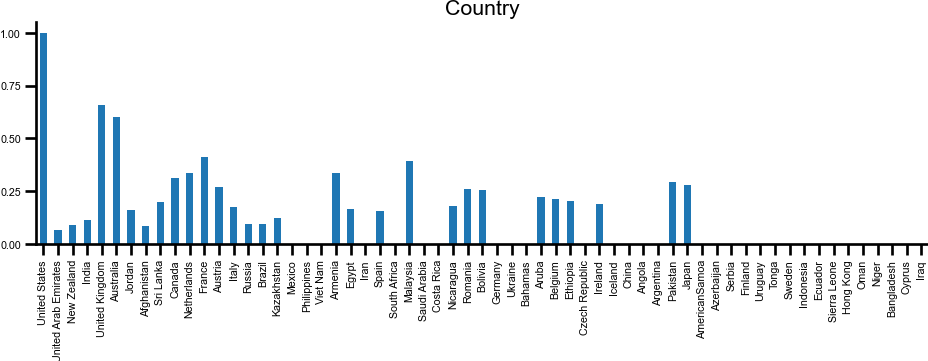

In [150]:
# 3. (0-1) normalize those ratios
mymax = np.max(list(rank_country.values()))
mymin = np.min(list(rank_country.values()))
normalize = lambda x: (x-mymin)/(mymax-mymin)
weight_country = {key:normalize(val) for key,val in rank_country.items()}
pd.Series(weight_country).plot.bar(figsize=(12,3), fontsize=8, title='Country');

In [151]:
weight_country['Viet Nam'], weight_country['AmericanSamoa']

(0.0, 0.0)

In [152]:
# correct two typos in dictionary
weight_country['Vietnam'] = weight_country.pop('Viet Nam')
weight_country['American Samoa'] = weight_country.pop('AmericanSamoa')

Number of unique ethnicities = 11
Length ranking dictionary  = 11


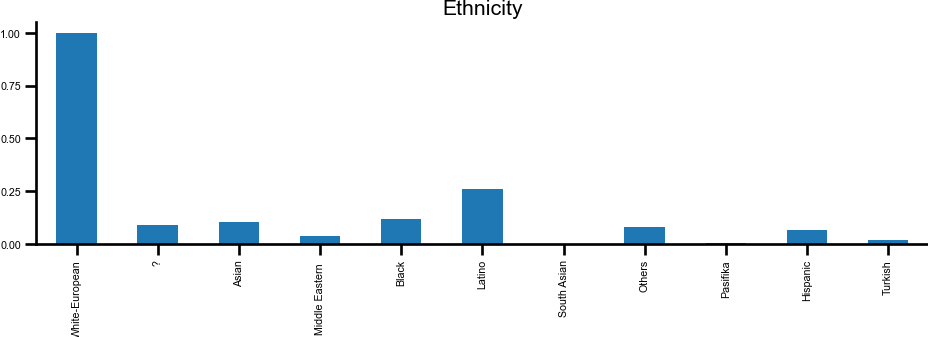

In [153]:
# Create ethnicity weight dictionary 
nethnicity = train['ethnicity'].nunique()
print(f'Number of unique ethnicities = {nethnicity}')

# 1. Count and rank ethnicities

ranking = range(1,nethnicity+1)[::-1]
ethnicity = train['ethnicity'].value_counts().index.to_list()
rank_ethnicity = dict( zip(ethnicity, ranking))
print(f'Length ranking dictionary  = {len(rank_ethnicity)}')

# 2. apply a pos/neg ratio to the rank
for key, val in rank_ethnicity.items():
    pos = np.sum( [(train_target==1) & (train['ethnicity']==key)] ) # when Class/ASD is yes and country is key
    neg = np.sum( [(train_target==0) & (train['ethnicity']==key)] ) # when Class/ASD is no  and country is key
    assert pos+neg == (train['ethnicity']==key).sum()
    if neg ==0:
        ratio = 0 # avoid zero-division error
    else:
        ratio = pos/neg
    rank_ethnicity[key] = ratio*val # n_total

# 3. (0-1) normalize those ratios
mymax = np.max(list(rank_ethnicity.values()))
mymin = np.min(list(rank_ethnicity.values()))
normalize = lambda x: (x-mymin)/(mymax-mymin)
weight_ethnicity = {key:normalize(val) for key,val in rank_ethnicity.items()}
pd.Series(weight_ethnicity).plot.bar(figsize=(12,3), fontsize=8, title='Ethnicity');

Number of unique relation = 5
Length ranking dictionary  = 5


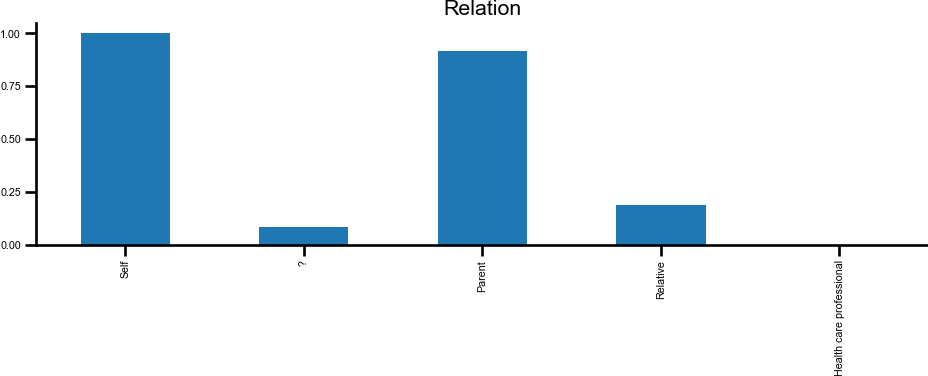

In [154]:
# Create ethnicity weight dictionary 
nrelation = train['relation'].nunique()
print(f'Number of unique relation = {nrelation}')


# 1. Count and rank ethnicities

ranking = range(1,nrelation+1)[::-1]
relation = train['relation'].value_counts().index.to_list()
rank_relation = dict( zip(relation, ranking))
print(f'Length ranking dictionary  = {len(rank_relation)}')


# 2. apply a pos/neg ratio to the rank
for key, val in rank_relation.items():
    pos = np.sum( [(train_target==1) & (train['relation']==key)] ) # when Class/ASD is yes and country is key
    neg = np.sum( [(train_target==0) & (train['relation']==key)] ) # when Class/ASD is no  and country is key
    assert pos+neg == (train['relation']==key).sum()
    if neg ==0:
        ratio = 0 # avoid zero-division error
    else:
        ratio = pos/neg
    rank_relation[key] = ratio*val # n_total

# 3. (0-1) normalize those ratios
mymax = np.max(list(rank_relation.values()))
mymin = np.min(list(rank_relation.values()))
normalize = lambda x: (x-mymin)/(mymax-mymin)
weight_relation = {key:normalize(val) for key,val in rank_relation.items()}
pd.Series(weight_relation).plot.bar(figsize=(12,3), fontsize=8, title='Relation');

In [155]:
# Group by age
for df in (train,test):
    df.loc[(df.age < 14),  'AgeGroup'] = 'children'
    df.loc[(df.age >= 14) &  (df.age < 24),  'AgeGroup'] = 'youth'
    df.loc[(df.age >= 24) & (df.age < 64),  'AgeGroup'] = 'adult'
    df.loc[(df.age >= 64),  'AgeGroup'] = 'senior'
    

Number of AgeGroup  = 4
Length ranking dictionary  = 4


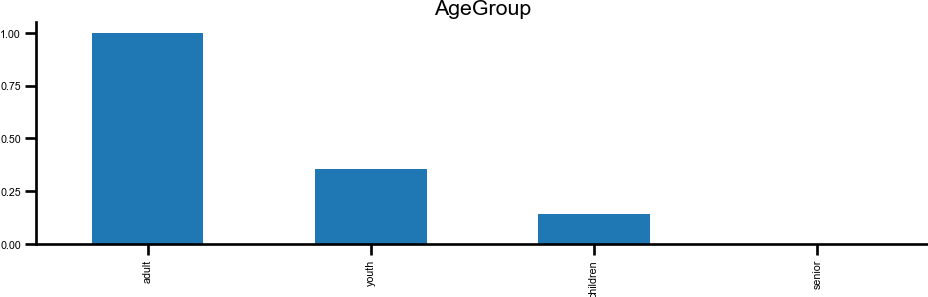

In [156]:
# Create age weight dictionary 
nage = train['AgeGroup'].nunique()
print(f'Number of AgeGroup  = {nage}')


# 1. Count and rank ages

ranking = range(1,nage+1)[::-1]
AgeGroup = train['AgeGroup'].value_counts().index.to_list()
rank_AgeGroup = dict( zip(AgeGroup, ranking))
print(f'Length ranking dictionary  = {len(rank_AgeGroup)}')


# 2. apply a pos/neg ratio to the rank
for key, val in rank_AgeGroup.items():
    pos = np.sum( [(train_target==1) & (train['AgeGroup']==key)] ) # when Class/ASD is yes and country is key
    neg = np.sum( [(train_target==0) & (train['AgeGroup']==key)] ) # when Class/ASD is no  and country is key
    assert pos+neg == (train['AgeGroup']==key).sum()
    if neg ==0:
        ratio = 0 # avoid zero-division error
    else:
        ratio = pos/neg
    rank_AgeGroup[key] = ratio*val # n_total

# 3. (0-1) normalize those ratios
mymax = np.max(list(rank_AgeGroup.values()))
mymin = np.min(list(rank_AgeGroup.values()))
normalize = lambda x: (x-mymin)/(mymax-mymin)
weight_AgeGroup = {key:normalize(val) for key,val in rank_AgeGroup.items()}
pd.Series(weight_AgeGroup).plot.bar(figsize=(12,3), fontsize=8, title='AgeGroup');

#Featureenginering&_selection

In [157]:
from sklearn.base import BaseEstimator, TransformerMixin

In [158]:
class ContinentTransformer(BaseEstimator, TransformerMixin):
    """
    Custom feature transform a Country in one of the 
    five continents of the world, 'Asia' 'Europe' 
    'Africa' 'Oceania' 'Americas', or 'nan'.
    It creates a 'continent' feature.
    
    To use it:
    >>> myregion = RegionTransformer(continent = data)
    >>> df = myregion.fit_transform(X = train)
    """

    def __init__(self, continent:dict) -> None:
        """
        Remove the list of features from a pandas 
        Dataframe object.
        
        Parameter
        ---------
        continent:  (dict) of countries/continent pairs.
        """

        self.continent = continent
        self.df = None
    
    
    def get_feature_names_out(self) -> List[str]:
        """
        Get column names (necessary for Pipelines)
        """
        
        if self.df is None:
            mycols = ['None']
        else:
            mycols =  self.df.columns.tolist()
            
        return mycols
        

    def fit(self, X:pd.DataFrame, y = None):
        """
        Remove the column lists and update dataset
        """
        
        df = X.copy()
        
        # correct 'AmericanSamoa and 'Viet Nam'
        typo1 = df[df['country_of_res'] == 'AmericanSamoa'].index
        typo2 = df[df['country_of_res'] == 'Viet Nam'].index
        
        if len(typo1):
            df['country_of_res'] = df['country_of_res'].cat.add_categories('American Samoa')
            for i in typo1:
                df.loc[i,'country_of_res'] = 'American Samoa'
        
        if len(typo2):
            df['country_of_res'] = df['country_of_res'].cat.add_categories('Vietnam')
            for i in typo2:
                df.loc[i,'country_of_res'] = 'Vietnam'
        
        
        df['continent'] = df['country_of_res'].map(self.continent)
        self.df = df
        
        return self
   
    def transform(self, X:pd.DataFrame = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with removed features.
        
        Parameter
        ---------
        dataframe:  Pandas DataFrame object
        """
        
        df = X.copy()
        
        # correct 'AmericanSamoa and 'Viet Nam'
        typo1 = df[df['country_of_res'] == 'AmericanSamoa'].index.tolist()
        typo2 = df[df['country_of_res'] == 'Viet Nam'].index.tolist()
        
        if len(typo1):
            df['country_of_res'] = df['country_of_res'].cat.add_categories('American Samoa')
            for i in typo1:
                df.loc[i,'country_of_res'] = 'American Samoa'
        
        if len(typo2):
            df['country_of_res'] = df['country_of_res'].cat.add_categories('Vietnam')
            for i in typo2:
                df.loc[i,'country_of_res'] = 'Vietnam'
        
        # Add region to dataset
        df['continent'] = df['country_of_res'].map(self.continent)
        return df

In [159]:
myregion = ContinentTransformer(continent = continent)
df_t = myregion.transform(X = train)

df_t[['country_of_res','continent']]

,country_of_res,continent
ID,,
1,United States,Americas
2,Australia,Oceania
3,United Kingdom,Europe
4,New Zealand,Oceania
5,Italy,Europe
...,...,...
796,United States,Americas
797,New Zealand,Oceania
798,Jordan,Asia


In [160]:
df_t.loc[77,['country_of_res','continent']] # check Vietnam

country_of_res    Vietnam
continent            Asia
Name: 77, dtype: object

In [161]:
df_t.loc[318,['country_of_res','continent']] # check American Samoa

country_of_res    American Samoa
continent                Oceania
Name: 318, dtype: object

In [162]:
class WeightEncoder(BaseEstimator, TransformerMixin):
    """
    Custom feature for Label encoding based on weight 
    of categorical variables. The weight is based on the 
    relative proportion associated with the success of the
    dependent variable.
    
    To use it:
    >>> myrank = {'united states': 1, 'spain':10}
    >>> myfreq = WeightEncoder(col_name = ['country_of_res'], weight = myrank)
    >>> df = myfreq.fit_transform(X = train)
    
    It creates a new feature called 'w_col_name'.
    """

    def __init__(self, col_name:str, weight:dict)-> None:
        """
        Remove the list of features from a pandas 
        Dataframe object.
        
        Parameter
        ---------
        col_name:  the variable to remove
        rank: (dict) containg the variable and frequency to 
        be substitued (eg. myrank = {'united states': 1, 'spain':10}
        
        """

        self.col_name = col_name
        self.weight = weight
        self.df = None
   
       

    def fit(self, X:pd.DataFrame, y = None):
        """
        Remove the column lists and update dataset
        """
        df = X.copy()
                
        df['w_' + self.col_name] = df[self.col_name].map(self.weight).fillna(0)   
        self.df = df
        
        return self
   
    def transform(self, X:pd.DataFrame = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with removed features.
        
        Parameter
        ---------
        dataframe:  Pandas DataFrame object
        """
        df = X.copy()
        
        # 0 if not found in dictionary
        df['w_' + self.col_name] = df[self.col_name].map(self.weight).fillna(0)
    
        return df

In [163]:
wencoder = WeightEncoder(col_name = 'country_of_res', weight = weight_country)
df = wencoder.fit_transform(X = train)
df[['w_country_of_res','country_of_res']]

,w_country_of_res,country_of_res
ID,,
1,1.000000,United States
2,0.600252,Australia
3,0.659595,United Kingdom
4,0.091032,New Zealand
5,0.174863,Italy
...,...,...
796,1.000000,United States
797,0.091032,New Zealand
798,0.159113,Jordan


In [164]:
df.loc[318,['w_country_of_res', 'country_of_res']]  # 'Viet Nam' and 'AmericanSamoa' 

w_country_of_res              0.0
country_of_res      AmericanSamoa
Name: 318, dtype: object

In [165]:
df.loc[77,['w_country_of_res', 'country_of_res']] # do not forget applying ContinentTransformer before

w_country_of_res         0.0
country_of_res      Viet Nam
Name: 77, dtype: object

In [166]:
class DropperTransformer(BaseEstimator, TransformerMixin):
    """
    Custom feature dropper to add to custom Pipelines.
    To use it:
    >>> mydropper = DropperTransformer(features = ['age'])
    >>> df = mydropper.fit_transform(X = train)
    """

    def __init__(self, features:List[str])-> None:
        """
        Remove the list of features from a pandas 
        Dataframe object.
        
        Parameter
        ---------
        features:  (list) of variables to remove
        """

        self.features = features
        self.df = None
    
    
    def get_feature_names_out(self)-> List[str]:
        """
        Get column names (necessary for Pipelines)
        """
        if self.df is None:
            mycols = ['None']
        else:
            mycols =  self.df.columns.tolist()
            
        return mycols
        

    def fit(self, X:pd.DataFrame, y = None):
        """
        Remove the column lists and update dataset
        """
        df = X.copy()
        self.df = df.drop(self.features, axis = 1)
        
        return self
   
    def transform(self, X:pd.DataFrame = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with removed features.
        
        Parameter
        ---------
        dataframe:  Pandas DataFrame object
        """
        df = X.copy()
        
        # Drop features
        self.df = df.drop(self.features, axis = 1)
        return self.df

In [167]:
mydropper = DropperTransformer(features = ['age_desc'])
mydropper.fit(train)
#df = mydropper.fit_transform(train)
for i, col in enumerate(mydropper.get_feature_names_out()):
    print(f'{i:2d} - {col}')

 0 - A1_Score
 1 - A2_Score
 2 - A3_Score
 3 - A4_Score
 4 - A5_Score
 5 - A6_Score
 6 - A7_Score
 7 - A8_Score
 8 - A9_Score
 9 - A10_Score
10 - age
11 - gender
12 - ethnicity
13 - jaundice
14 - autism
15 - country_of_res
16 - used_app_before
17 - result
18 - relation
19 - AgeGroup


Feature selection with Pearson's Chi-square Test for Independence

In [168]:
from sklearn.feature_selection import chi2

In [169]:
from sklearn.preprocessing import OneHotEncoder

In [170]:
binary_features = ['gender', 'jaundice', 'autism', 'used_app_before']
binary_encoder = OneHotEncoder(sparse=False, drop= 'if_binary')
#foo = binary_encoder.fit_transform(train[binary_features])
#cols = binary_encoder.get_feature_names_out()

chi_score, p = chi2(X = binary_encoder.fit_transform(train[binary_features])  ,y = train_target)
star = p <= 0.05 # if they are dependent, probability of Ho (independency) must be lower than 5%
pd.DataFrame(zip(binary_features, chi_score, p, star), columns=['category', 'Chi-Square', 'p-value', 'P<0.05'])

,category,Chi-Square,p-value,P<0.05
0,gender,6.462530,1.101727e-02,True
1,jaundice,21.981247,2.753276e-06,True
2,autism,97.114903,6.541865e-23,True
3,used_app_before,0.192265,6.610378e-01,False


In [171]:
# Note that A*_Score are also binary variables, we will test if they are related to the independent variable
mylist = [f'A{i}_Score' for i in range(1,10)]

chi_score, p = chi2(X = binary_encoder.fit_transform(train[mylist])  ,y = train_target)
star = p <= 0.05
pd.DataFrame(zip(mylist, chi_score, p, star), columns=['category', 'Chi-Square', 'p-value', 'P<0.05'])

,category,Chi-Square,p-value,P<0.05
0,A1_Score,28.087740,1.159380e-07,True
1,A2_Score,82.757731,9.275235e-20,True
2,A3_Score,164.029628,1.490354e-37,True
3,A4_Score,123.063444,1.350604e-28,True
4,A5_Score,87.289627,9.373823e-21,True
5,A6_Score,186.356096,1.984980e-42,True
6,A7_Score,90.494446,1.854969e-21,True
7,A8_Score,10.842539,9.919460e-04,True
8,A9_Score,158.731010,2.142467e-36,True


# Designing preprocessing Pipeline

In [172]:
# Transformation: create processing pipeline
#from sklearn.pipeline import make_pipeline # to concatenate estimators and transformers (like Pipeline)
#from sklearn.compose import make_column_transformer # to apply transformers to categories (ColumnTransformer)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [173]:
country = ('country', ContinentTransformer(continent = continent)) # creates continent
w_country = ('weight_country', WeightEncoder(col_name = 'country_of_res', weight = weight_country)) # creates w_contry_of_res 
w_ethnicity = ('weight_ethnicity', WeightEncoder(col_name = 'ethnicity', weight = weight_ethnicity)) # creates w_ethnicity
w_relation = ('weight_relation', WeightEncoder(col_name = 'relation', weight = weight_relation)) # creates w_relation
#w_age = ('weight_age', WeightEncoder(col_name = 'AgeGroup', weight=weight_AgeGroup)) # creates_w_AgeGroup

dropper = ('dropper', DropperTransformer(features = ['age_desc', 'gender', 'used_app_before','country_of_res']))

in_process = (country, w_country, w_ethnicity, w_relation, dropper)
pipeline = Pipeline(steps = in_process)

df = pipeline.fit_transform(train)
#pipeline[1].get_feature_names_out()
for i,col in enumerate(pipeline[-1].get_feature_names_out()):
    print(f'[{i:2d}] -> {col}')

[ 0] -> A1_Score
[ 1] -> A2_Score
[ 2] -> A3_Score
[ 3] -> A4_Score
[ 4] -> A5_Score
[ 5] -> A6_Score
[ 6] -> A7_Score
[ 7] -> A8_Score
[ 8] -> A9_Score
[ 9] -> A10_Score
[10] -> age
[11] -> ethnicity
[12] -> jaundice
[13] -> autism
[14] -> result
[15] -> relation
[16] -> AgeGroup
[17] -> continent
[18] -> w_country_of_res
[19] -> w_ethnicity
[20] -> w_relation


In [174]:
# =====================================================================
# Tuples for Pipeline contain only the 'key' & Transformers
# =====================================================================
country = ('country', ContinentTransformer(continent = continent)) # creates continent
w_country = ('weight_country', WeightEncoder(col_name = 'country_of_res', weight = weight_country)) # creates w_contry_of_res 
w_ethnicity = ('weight_ethnicity', WeightEncoder(col_name = 'ethnicity', weight = weight_ethnicity)) # creates w_ethnicity
w_relation = ('weight_relation', WeightEncoder(col_name = 'relation', weight = weight_relation)) # creates w_relation
#w_age = ('weight_age', WeightEncoder(col_name = 'AgeGroup', weight=weight_AgeGroup)) # creates_w_AgeGroup

dropper = ('dropper', DropperTransformer(features = ['age_desc', 'gender', 'used_app_before','country_of_res']))

# =====================================================================
# Tuples for ColumnTransformer contain only the 'key',Transformers,col
# =====================================================================
z_scoring = ('z_scoring', StandardScaler(), [10, 14] ) # age, result
binarize = ('binarize', OneHotEncoder(sparse=False, drop= 'if_binary'), [12,13] ) # jaundice, austim
one_hot =  ('one_hot',  OneHotEncoder(sparse=False, handle_unknown='ignore'), [11,15,16,17] ) # ethnicity, relation, AgeGroup, ontinent

col_transformer = ColumnTransformer(transformers = (z_scoring, binarize, one_hot), remainder = 'passthrough')

col_preprocess = ('col_transformer', col_transformer)

preprocess = Pipeline( steps = (country, w_country, w_ethnicity, w_relation, dropper, col_preprocess))
preprocess

Pipeline(steps=(('country',
                 ContinentTransformer(continent={'Afghanistan': 'Asia',
                                                 'Albania': 'Europe',
                                                 'Algeria': 'Africa',
                                                 'American Samoa': 'Oceania',
                                                 'Andorra': 'Europe',
                                                 'Angola': 'Africa',
                                                 'Anguilla': 'Americas',
                                                 'Antarctica': 'Antarctica',
                                                 'Antigua and Barbuda': 'Americas',
                                                 'Argentina': 'Americas',
                                                 'Armenia': 'Asia',
                                                 'Aruba': 'Americas',
                                                 'Australia': 'Oceania',
                                                 'Austria'...
                ('dropper',
                 DropperTransformer(features=['age_desc', 'gender',
                                              'used_app_before',
                                              'country_of_res'])),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=(('z_scoring', StandardScaler(),
                                                  [10, 14]),
                                                 ('binarize',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  [12, 13]),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [11, 15, 16, 17]))))))

In [175]:
preprocess.fit(test) # we need to fit the pipeline to obtain get_features_names_out()

Pipeline(steps=[('country',
                 ContinentTransformer(continent={'Afghanistan': 'Asia',
                                                 'Albania': 'Europe',
                                                 'Algeria': 'Africa',
                                                 'American Samoa': 'Oceania',
                                                 'Andorra': 'Europe',
                                                 'Angola': 'Africa',
                                                 'Anguilla': 'Americas',
                                                 'Antarctica': 'Antarctica',
                                                 'Antigua and Barbuda': 'Americas',
                                                 'Argentina': 'Americas',
                                                 'Armenia': 'Asia',
                                                 'Aruba': 'Americas',
                                                 'Australia': 'Oceania',
                                                 'Austria'...
                ('dropper',
                 DropperTransformer(features=['age_desc', 'gender',
                                              'used_app_before',
                                              'country_of_res'])),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=(('z_scoring', StandardScaler(),
                                                  [10, 14]),
                                                 ('binarize',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  [12, 13]),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [11, 15, 16, 17]))))])

In [176]:
def remove_prefix(mystring:str)-> str:
    """
    Removes prefix until '__'
    e.g 'z_scoring__age' to 'age'
    """
    mystring = mystring.replace(r"__","*") # 'replace double underscore with *
    return mystring[mystring.find("*")+1:]

remove_prefix('z_scoring__age')

'age'

In [177]:
mycols = [remove_prefix(mystring= col_name) for col_name in preprocess[-1].get_feature_names_out()]
mycols

['age',
 'result',
 'jaundice_yes',
 'autism_yes',
 'ethnicity_Asian',
 'ethnicity_Black',
 'ethnicity_Hispanic',
 'ethnicity_Latino',
 'ethnicity_Middle Eastern ',
 'ethnicity_Others',
 'ethnicity_Pasifika',
 'ethnicity_South Asian',
 'ethnicity_Turkish',
 'ethnicity_White-European',
 'ethnicity_others',
 'relation_?',
 'relation_Health care professional',
 'relation_Parent',
 'relation_Relative',
 'relation_Self',
 'AgeGroup_adult',
 'AgeGroup_children',
 'AgeGroup_senior',
 'AgeGroup_youth',
 'continent_Africa',
 'continent_Americas',
 'continent_Asia',
 'continent_Europe',
 'continent_Oceania',
 'A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score',
 'w_country_of_res',
 'w_ethnicity',
 'w_relation']

In [178]:
from sklearn.preprocessing import FunctionTransformer

# pipeline to add columns 
# see here https://datascience.stackexchange.com/questions/75449/is-there-a-way-to-force-a-transformer-to-return-a-pandas-dataframe
pandarized = ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = mycols)))
preprocess = Pipeline( steps = (country, w_country, w_ethnicity, w_relation, dropper, col_preprocess, pandarized))

In [179]:
# Exploration: there are no missing values in both train and test datasets
assert test.isnull().values.any() == False, 'test dataset contains missing values'
assert train.isnull().values.any() == False, 'train dataset contains missing values'

In [180]:
# Check the number of resulting variables are the same
#preprocess.fit_transform(X=train).shape, preprocess.fit_transform(X=test).shape

In [181]:
# We first apply the preprocessing pipeline
Xtrain = preprocess.fit_transform(X = train)
Xtest = preprocess.fit_transform(X = test)

# check resulting variables are the same after preprocessing
assert (Xtrain.shape[1] == Xtest.shape[1]), 'train and set contain different number of independent variables'

# check the same number of independent variables
assert (Xtrain.shape[0] == train_target.shape[0]), 'train changed the number of observations'

#Xtrain.shape, Xtest.shape, train_target.shape

# Oversampling

Oversampling:
SMOTEENN is described in Batista et al (2004). It combines the SMOTE to generate synthetic examples for minority class with ENN to delete some observations from both classes that are identified as having different class between the observation’s class and its K-nearest neighbor majority class. 

In [182]:
#from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [183]:
sm = SMOTEENN(enn = EditedNearestNeighbours(sampling_strategy='all', kind_sel="mode"), random_state = 42, n_jobs =-1)
ov_Xtrain, ov_ytrain = sm.fit_resample(X = Xtrain, y = train_target)

/Users/krish/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [184]:
ov_ytrain.value_counts() # see now balanced target 

1    601
0    499
Name: Class/ASD, dtype: int64

In [185]:
train_target.value_counts() # umbalanced

0    615
1    185
Name: Class/ASD, dtype: int64

In [186]:
ov_Xtrain.shape, ov_ytrain.shape

((1100, 42), (1100,))

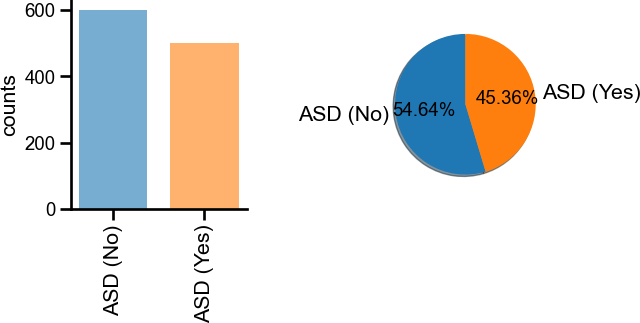

In [187]:
# Exploration: visualization of target variable

autistic = ov_ytrain.value_counts() 

fig, ax = plt.subplots(1,2, figsize =(6,3))
fig.tight_layout(pad = 1, h_pad = 2, w_pad = 4)

mylabels = ['ASD (No)', 'ASD (Yes)']
mycolors = ['tab:blue', 'tab:orange']

ax[0].bar(x=mylabels, height = autistic, color = mycolors, width = 0.75, alpha = .6)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_ylabel('counts')#, ax[0].set_yticks(np.arange(0,4000,500))

ax[1].pie(autistic.values, labels = mylabels, colors = mycolors, autopct='%2.2f%%',shadow=True, startangle=90);

# Training

We will test the accuracy of our models when training the dataset with the most common classification methods.

In [188]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression






# 1. Instances of all models 
RF_clf = RandomForestClassifier(random_state = 42)

GB_clf = GradientBoostingClassifier(random_state=42)
ET_clf = ExtraTreesClassifier(random_state = 42)

LR_clf = LogisticRegression(random_state = 42, solver='liblinear', max_iter = 1500)



In [189]:
# minimal reporting here
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

In [190]:
# minimal train/test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# we train with one-third of the dataset for simplicity
X_train, X_test, y_train, y_test = train_test_split(ov_Xtrain, ov_ytrain, test_size=1/3., random_state=42)

# Random_Forest

In [191]:
# from sklearn.ensemble import RandomForestClassifier

In [192]:
# RF_clf = RandomForestClassifier(random_state = 42) # instance of model with default methods

In [193]:
# train 
RF_clf.fit(X = X_train, y = y_train) # training with 2/3 of the balanced data

prediction = RF_clf.predict(X = X_test) # predict the rest 1/3 of the balanced data

print(classification_report(y_test, prediction)) # accuracy 0.97

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       174
           1       0.99      0.97      0.98       193

    accuracy                           0.98       367
   macro avg       0.98      0.98      0.98       367
weighted avg       0.98      0.98      0.98       367



In [194]:
def plot_metrics(model, X:np.array, y_target:np.array) -> plt.figure:
    """
    Plots confusion matrix and Receiver Operating Characteristic
    (ROC) curve of the classifier
    
    Arguments:
    ----------
    predictor
    X (array): input matrix
    y_target (array) : target vector
    """
    prediction = model.predict( X )
    
    # Compute donfusion matrix
    cm = confusion_matrix(y_target, prediction, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    fig.tight_layout(pad = 3, h_pad = 2, w_pad = 4)
    fig.suptitle(type(model).__name__)
    ax[0] = disp.plot(ax = ax[0])

    
    # ROC curve
    y_pred_prob = model.predict_proba(X)[::,1]
    test_FP, test_TP, thresholds = roc_curve(y_target ,y_pred_prob)
    auc = roc_auc_score(y_target, y_pred_prob)
    
    ax[1].plot(test_FP, test_TP, color='C0', label = f'AUC = {auc:2.2f}')
    ax[1].plot([0, 1], [0, 1],'r--', lw=1)

    ax[1].legend(loc =4, fontsize=10);

    ax[1].set_ylabel('True Positive (TP)', fontsize=10);
    ax[1].set_xlabel('False Positive (FP)', fontsize=10);

    ax[1].set_title('Receiver Operating Characteristic (ROC) curve', fontsize=10);
    
    #return fig

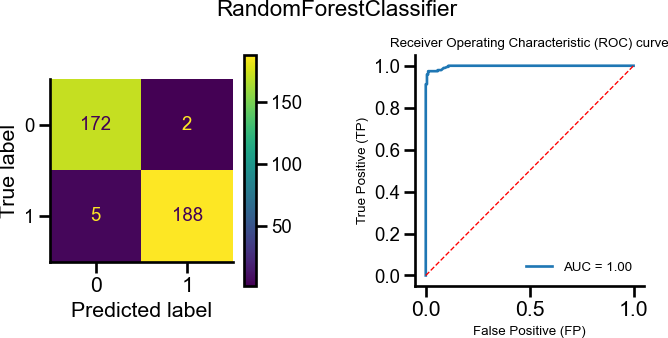

In [195]:
# RandomForest performance on test dataset (1/3 of the training dataset)
plot_metrics(model = RF_clf,  X = X_test, y_target = y_test)

In [196]:
def get_predictionfile(prediction: np.array, filename:str):
    """
    Return submission file
    
    Arguments:
    prediction: (array)
        the estimator result of predict() method  
    filename : (str)
        filename to be saved
    """
    # test input size
    check_shape = prediction.shape == (200,)
    assert check_shape, f'prediction shape expected (200,), got: {prediction.shape}'
    
    df = pd.DataFrame({'ID': test.index, 'Class/ASD': prediction})
    print(f'{filename} with {df.shape[0]} predictions created')
    return df.to_csv(filename, index=False)

In [197]:
# we test our trained model with the Xtest restulting from the competition 
# get_predictionfile(RF_clf.predict_proba(Xtest)[:,1], 'RF_submission_test_size3.csv') # Score: 

In [198]:
cv_score = cross_val_score(estimator = RF_clf, X = Xtrain, y = train_target, scoring = "roc_auc", cv = 4, n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score)) # that's closer to competition

0.9040594775599808 0.04190234857580873


# Logistic_Regression

In [199]:
#from sklearn.linear_model import LogisticRegression

In [200]:
# LR_clf = LogisticRegression(random_state = 42,solver='liblinear')#, max_iter = 1500)

In [201]:
LR_clf.fit(X = X_train, y = y_train) # training with 2/3 of the data

prediction = LR_clf.predict(X = X_test) # predict the rest 1/3 

print(classification_report(y_test, prediction)) # accuracy 0.96

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       174
           1       0.91      0.93      0.92       193

    accuracy                           0.92       367
   macro avg       0.92      0.92      0.92       367
weighted avg       0.92      0.92      0.92       367



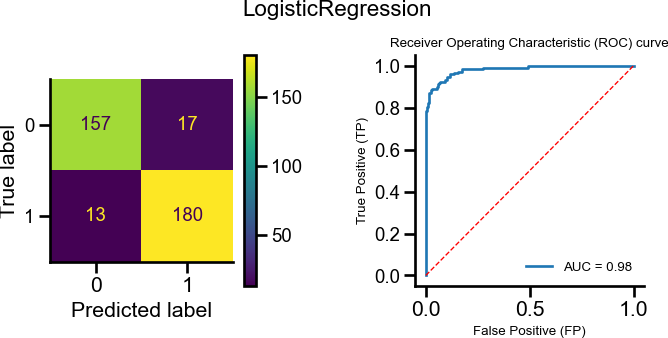

In [202]:
# Logistic Regression performance on test dataset (1/5 of the training dataset)
plot_metrics(model = LR_clf,  X = X_test, y_target = y_test)

In [203]:
# we test our trained model with the Xtest restulting from the competition 
# get_predictionfile(LR_clf.predict_proba(Xtest)[:,1], 'LR_submission_test_size3.csv') # Score: 

In [204]:
cv_score = cross_val_score(estimator = LR_clf, X = Xtrain, y = train_target, scoring = "roc_auc", cv = 4, n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score)) # that's closer to competition

0.9098144562957917 0.03669965904796159


# Extra_Tree

In [205]:
#from sklearn.tree import DecisionTreeClassifier

In [206]:
#DT_clf = DecisionTreeClassifier(random_state=42)

In [207]:
ET_clf.fit(X = X_train, y = y_train) # training with 2/3 of the data

prediction = ET_clf.predict(X = X_test) # predict the rest 1/3 

print(classification_report(y_test, prediction)) # accuracy 0.98

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       174
           1       0.98      0.98      0.98       193

    accuracy                           0.98       367
   macro avg       0.98      0.98      0.98       367
weighted avg       0.98      0.98      0.98       367



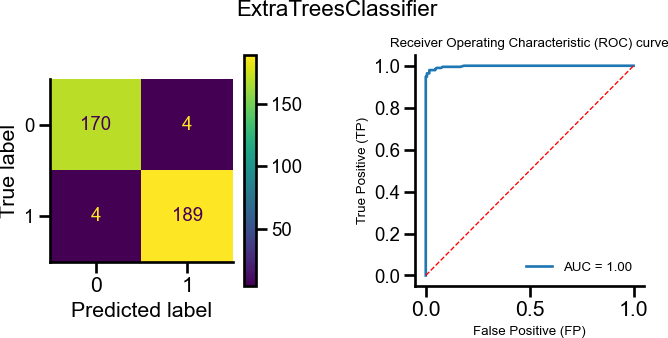

In [208]:
# Logistic Regression performance on test dataset (1/3 of the training dataset)
plot_metrics(model = ET_clf,  X = X_test, y_target = y_test)

In [209]:
# we test our trained model with the Xtest restulting from the competition 
# get_predictionfile(prediction = ET_clf.predict_proba(Xtest)[:,1], filename = 'ET_submission_test_size3.csv') # Score: 

In [210]:
cv_score = cross_val_score(estimator = ET_clf, X = Xtrain, y = train_target, scoring = "roc_auc", cv = 4, n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score)) # that's closer to competition

0.897428059189364 0.034554061787799566


# Gradient_Boosting

In [211]:
GB_clf.fit(X = X_train, y = y_train) # training with 2/3 of the data

prediction = GB_clf.predict(X = X_test) # predict the rest 1/3 

print(classification_report(y_test, prediction)) # accuracy 0.98

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       174
           1       0.98      0.98      0.98       193

    accuracy                           0.98       367
   macro avg       0.98      0.98      0.98       367
weighted avg       0.98      0.98      0.98       367



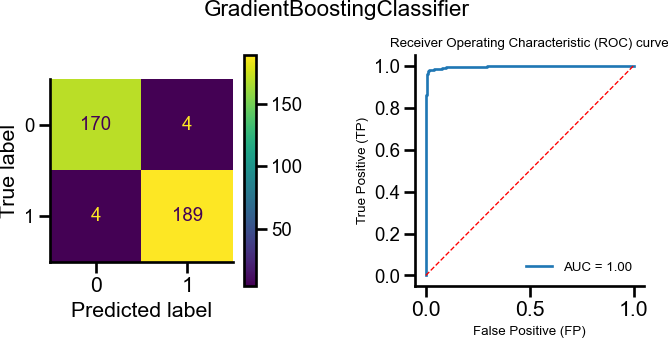

In [212]:
# Gradient Boosting performance on test dataset (1/3 of the training dataset)
plot_metrics(model = GB_clf,  X = X_test, y_target = y_test)

In [213]:
# we test our trained model with the Xtest restulting from the competition 
# get_predictionfile(prediction = GB_clf.predict_proba(Xtest)[:,1], filename = 'GB_submission_test_size3.csv') # Score: 

In [214]:
cv_score = cross_val_score(estimator = GB_clf, X = Xtrain, y = train_target, scoring = "roc_auc", cv = 4, n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score)) # that's closer to competition

0.9027372848895676 0.03891068829105948


# Test_All_Models

In [215]:
classifiers = [RF_clf,  ET_clf, LR_clf, GB_clf]
print(f'We test {len(classifiers)} classifiers')

We test 4 classifiers


In [216]:
from sklearn.model_selection import StratifiedKFold

# We use a 4-fold cross validation of Xtrain, that creates 200 entries blocks
myKFold = StratifiedKFold(n_splits = 4, shuffle = True, random_state=42) #

In [217]:
mydict = dict()

name = list()
roc_score = list()
stdev =  list()

for clf in classifiers:
    name.append(type(clf).__name__)
    clf.fit(X = ov_Xtrain, y = ov_ytrain ) # train balanced dataset
    mycv = cross_val_score(clf, Xtrain, y = train_target, scoring = "roc_auc", cv = myKFold, n_jobs=-1) # score unbalanced dataset
    roc_score.append( np.mean(mycv)*100 )
    stdev.append( np.std(mycv) *100)

mydict['Classifier'] = name
mydict['roc_auc(%)'] = roc_score
mydict['stdev(%)'] = stdev

mybase = pd.DataFrame.from_dict(mydict).set_index('Classifier')
mybase

,roc_auc(%),stdev(%)
Classifier,,
RandomForestClassifier,90.007929,1.587507
ExtraTreesClassifier,89.244213,1.784509
LogisticRegression,91.082770,1.184810
GradientBoostingClassifier,90.670229,0.956550


In [218]:
mybase[mybase['roc_auc(%)']>90]

,roc_auc(%),stdev(%)
Classifier,,
RandomForestClassifier,90.007929,1.587507
LogisticRegression,91.082770,1.184810
GradientBoostingClassifier,90.670229,0.956550
